# **STOCK ANALYSIS CHATBOT**

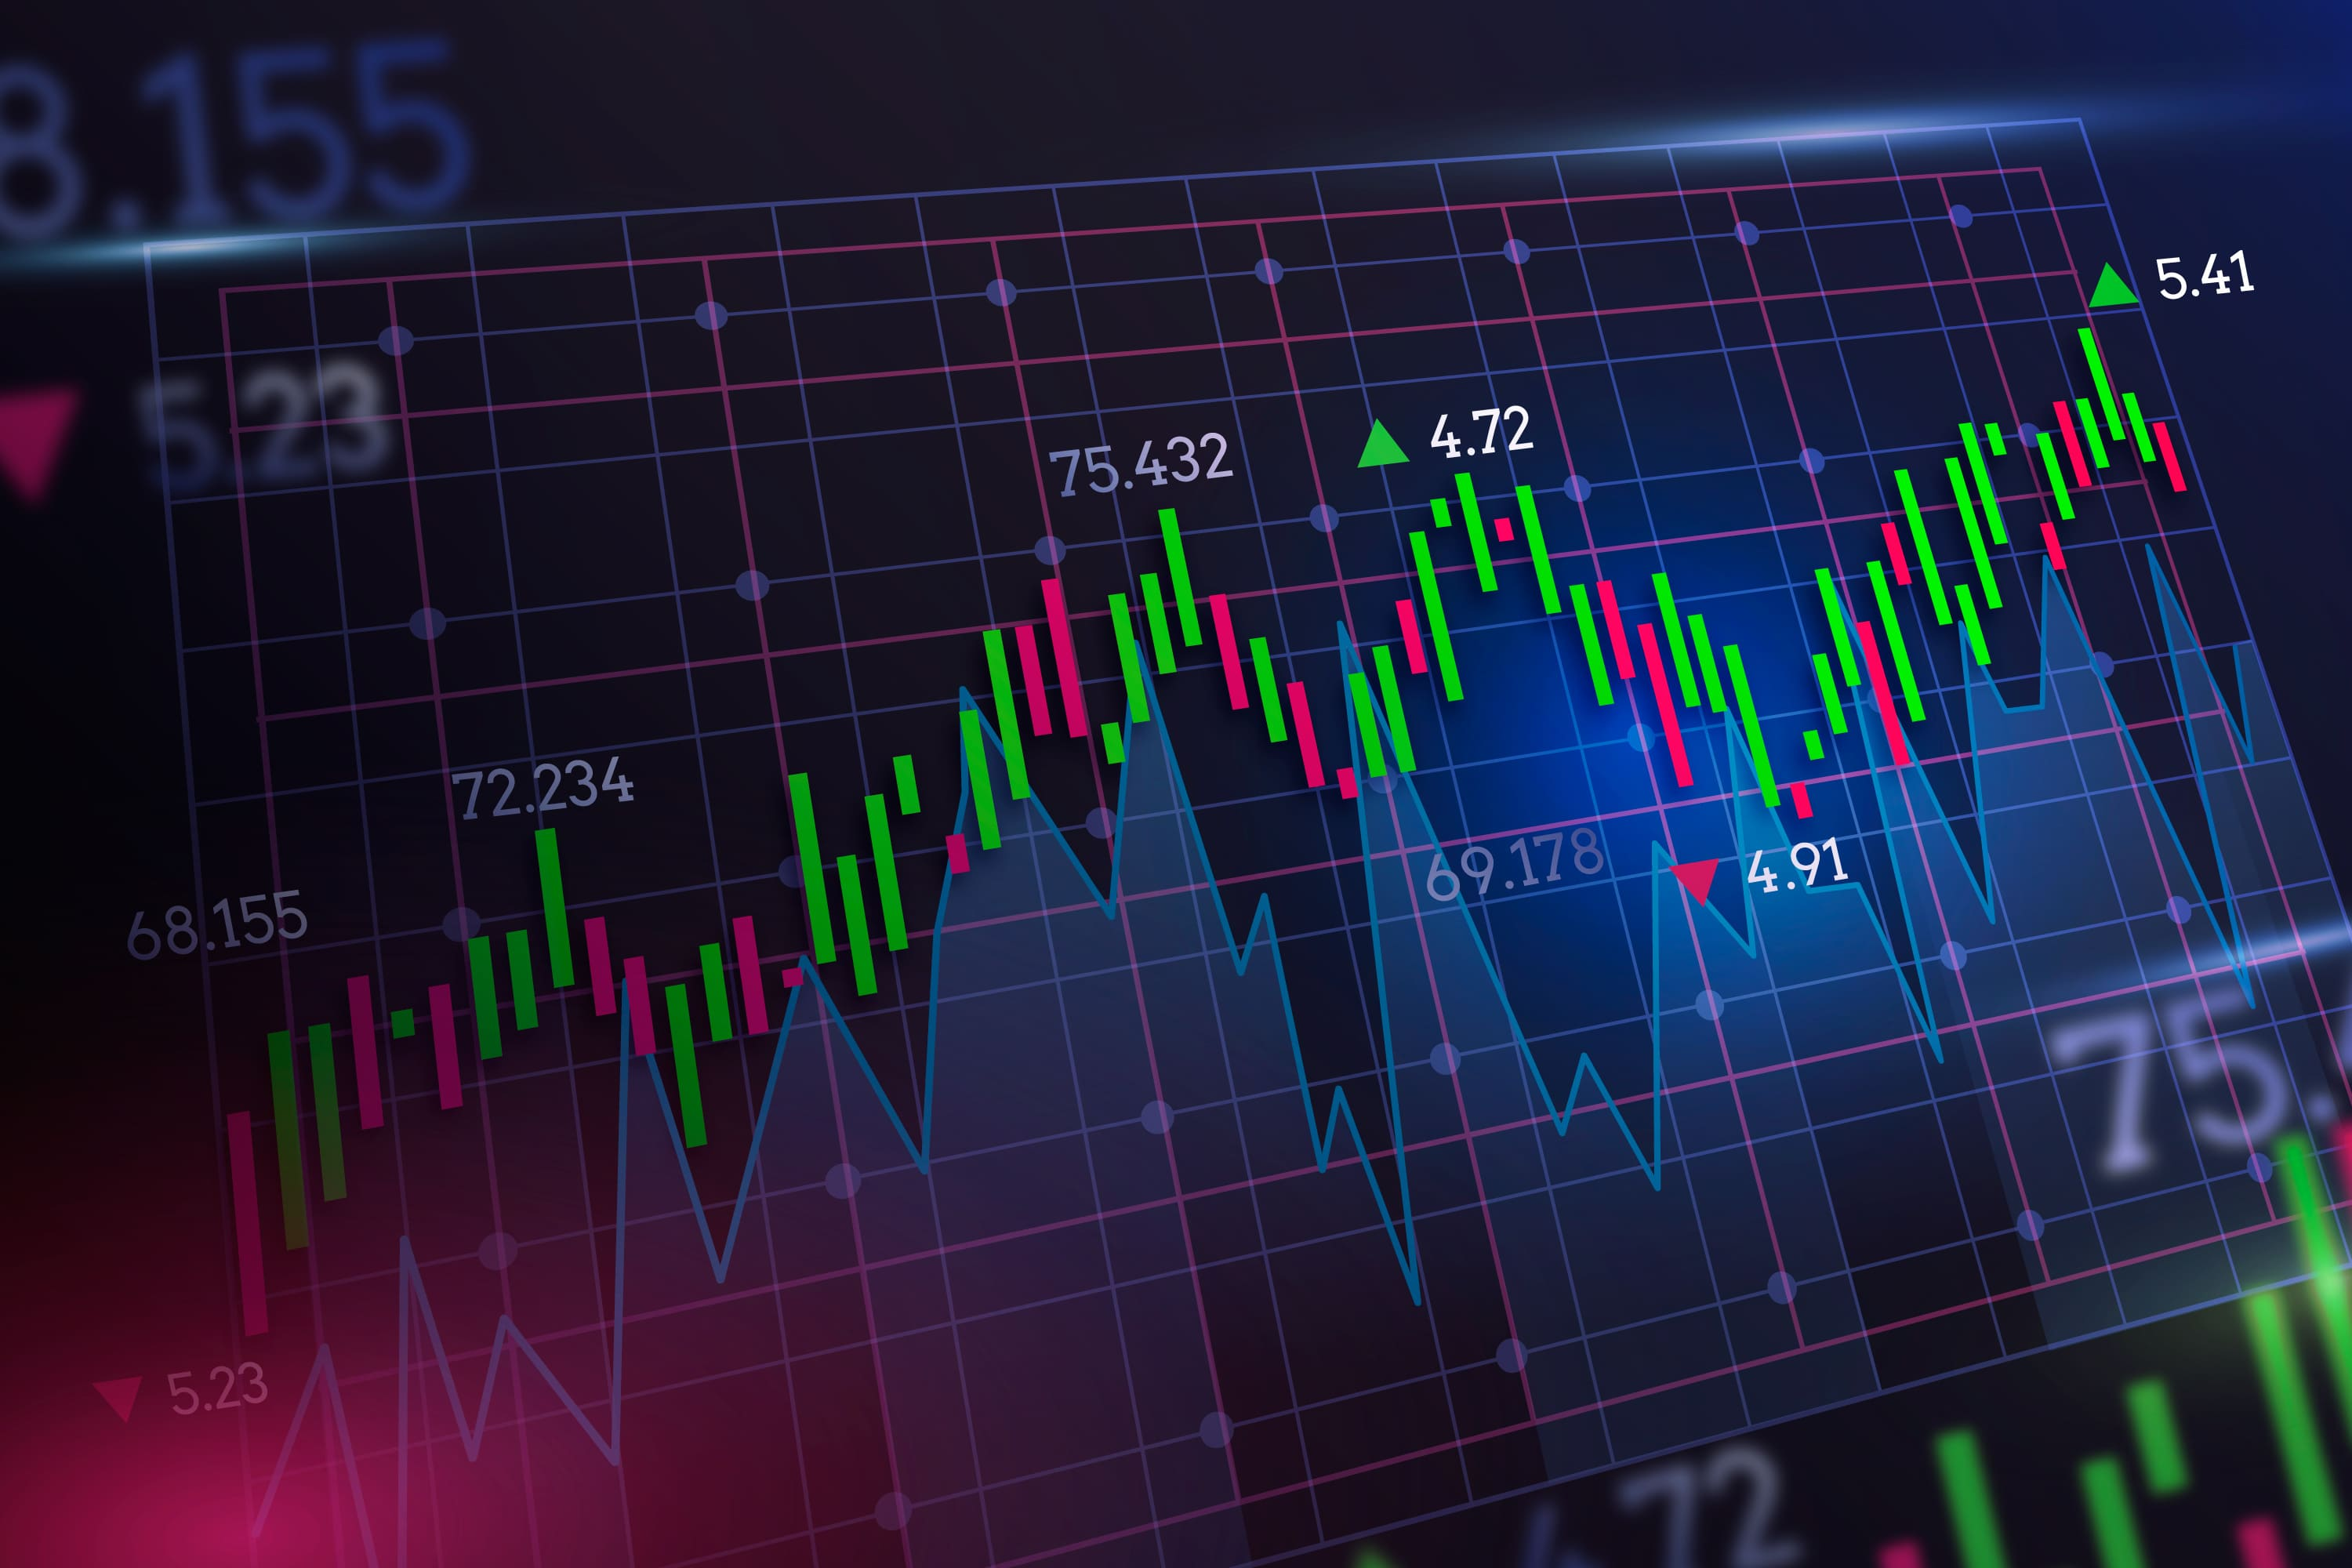

In an era where information is paramount, understanding the stock market can feel like navigating a dense and ever-shifting landscape. That's why I embarked on a fascinating project: building an intelligent stock analysis chatbot – a digital companion designed to make market insights more accessible and understandable to anyone, anywhere.

This Python project aims to build a stock analysis chatbot that can respond to user queries about stock market information. It fetches real-time or historical stock data using the **Alpha Vantage API**, analyzes trends and calculates technical indicators like **Simple Moving Averages (SMA)** and the **Relative Strength Index (RSI)**. The analyzed data is then stored and retrieved from a **ChromaDB** instance, enabling **Retrieval-Augmented Generation (RAG)** to provide contextually relevant answers using a Gemini language model. The chatbot can handle queries for single stocks and also compare multiple stocks, providing concise analyses and interpretations of the data, with an additional evaluation mechanism to assess the quality of the chatbot's responses based on predefined criteria.

This stock analysis chatbot addresses the increasing demand for accessible and intelligent financial information. It empowers users, regardless of their technical expertise, to gain insights into stock market trends and key indicators through natural language interaction.

---

**PS.: This project was carried out using Kaggle Notebook.**

---

## **Watch the Video Walkthrough**

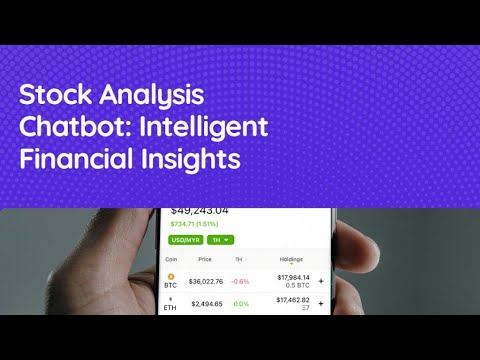

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('3KL-pl2e3FE', width=640, height=360)

## **Let's Get Started!!**

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install -U -q "google-genai==1.7.0"
!pip install -qU "chromadb==0.6.3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 64.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 84.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 k

## **1. Import Neccessary Libraries**

In [3]:
from google import genai
import chromadb
from chromadb.utils import embedding_functions
import requests
import pandas as pd
import os
import re
import time
import json
from IPython.display import HTML, Markdown, display

import warnings
warnings.filterwarnings("ignore")


from google.api_core import retry


is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

## **2. Setup APIs Configuration**

To execute the next cell, you need to save your GOOGLE API key (get it from from  [AI Studio](https://aistudio.google.com/app/apikey)) in a Kaggle secret called `GOOGLE_API_KEY`, and your AlphaVantage API key (get it from from  [Alpha_Vantage](https://www.alphavantage.co/support/#api-key)) in a kaggle secret called `ALPHA_VANTAGE_API_KEY`. To add the keys via Kaggle secrets, go to the **Add-ons** menu, select **Secrets**, and follow the prompts to add your keys and ensure you enable them (as shown by the ticks in the image below) to make it accessible to this notebook.

**NOTE THAT** both APIs have their respective rate limits. For instance, the free Alpha Vantage API has a rate limit of 5 calls/minute and 25 calls/day.

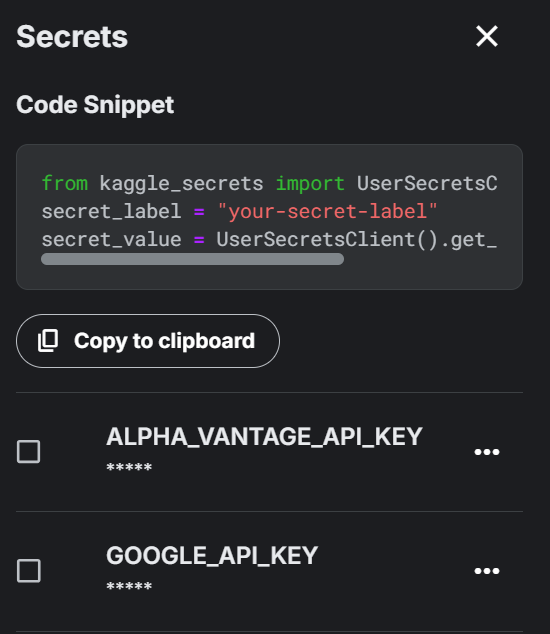

In [12]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
alpha_vantage_key = UserSecretsClient().get_secret("ALPHA_VANTAGE_API_KEY")

In [13]:
# Instantiate the Client object to make requests to the Google API
client = genai.Client(api_key=GOOGLE_API_KEY)

# Generate the list of available gemini models
print("List of available gemini models")
print("")
for model in client.models.list():
  print(model.name)

# Generate the list of available embedding models
print("")
print("List of available embedding models")
print("")
for m in client.models.list():
    if "embedContent" in m.supported_actions:
        print(m.name)

List of available gemini models

models/chat-bison-001
models/text-bison-001
models/embedding-gecko-001
models/gemini-1.0-pro-vision-latest
models/gemini-pro-vision
models/gemini-1.5-pro-latest
models/gemini-1.5-pro-001
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash-001
models/gemini-1.5-flash-001-tuning
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-1.5-flash-8b-exp-0827
models/gemini-1.5-flash-8b-exp-0924
models/gemini-2.5-pro-exp-03-25
models/gemini-2.5-pro-preview-03-25
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models

We will use `gemini-2.0-flash` as the primary and evaluator model, and `gemini-embedding-exp-03-07` as our embedding model.

# **Querying the Model without Fine-Tuning and RAG**

Let's see how a generic Gemini model that has not been fine-tuned responds to user queries about the stock market.

In [14]:
response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents='Compare the trends for GOOGL and MSFT')
print(response.text)

Let's analyze the trends of GOOGL (Alphabet Inc. - Google) and MSFT (Microsoft Corporation) from a few different perspectives.  Keep in mind that stock market analysis is forward-looking and trends can change quickly based on various factors.  This is not financial advice.

**1. Stock Price Performance (Recent and Longer-Term):**

*   **Recent (Last Year/6 Months):**  *Generally both companies have performed well, but the exact percentage gains can change day to day.  You need to look at a current stock chart on a site like Google Finance, Yahoo Finance, or Bloomberg to get precise figures.* As of late 2023 and early 2024, both companies have benefitted significantly from the AI hype and growing optimism about the tech sector's recovery. One company might be slightly outperforming the other depending on the exact period you examine.
*   **Longer-Term (Past 5 Years):** Both have demonstrated very strong growth over the past 5 years. They are considered core holdings for many investors. 

In [15]:
response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents='what is the RSI for GOOGL and MSFT')
print(response.text)

I can't give you the exact, real-time RSI values for GOOGL and MSFT right now. This is because:

*   **RSI is a dynamic indicator:** It changes constantly based on the most recent price movements. I am an AI and do not have access to live market data.
*   **RSI Calculations Vary:** The specific RSI value depends on the calculation period (usually 14 periods, but sometimes 9 or other lengths are used).

**To find the current RSI for GOOGL (Alphabet Inc.) and MSFT (Microsoft), you need to use a reliable financial data source.**

Here's where you can find it:

*   **Financial Websites:**
    *   Google Finance (search "GOOGL stock" or "MSFT stock")
    *   Yahoo Finance (finance.yahoo.com)
    *   Bloomberg (bloomberg.com)
    *   TradingView (tradingview.com)
    *   MarketWatch (marketwatch.com)
*   **Brokerage Platforms:** Your online brokerage account (e.g., Fidelity, Schwab, Robinhood, etc.) will typically show the RSI along with other technical indicators.
*   **Financial News Apps:

Judging from the responses above, we can see that the Gemini model fails to provide relevant and concise responses to the user queries. Without implementing fine-tuning and RAG processes, the model fails to provide up-to-date information and retrieve relevant data. Hence, we will create an LLM capable of providing up-to-date and relevant financial insights and information to users seeking to understand the financial market. 

## **3. Setup Vetor Database (ChromaDB)**

In [16]:
# Set up ChromaDB
CHROMA_DB_PATH = "stock_chroma_db"
COLLECTION_NAME = "stock_analysis"
chroma_client = chromadb.PersistentClient(path=CHROMA_DB_PATH)

try:
    google_ef = embedding_functions.GoogleGenerativeAiEmbeddingFunction(
        api_key=GOOGLE_API_KEY,
        model_name="models/gemini-embedding-exp-03-07"
    )
    collection = chroma_client.get_or_create_collection(name=COLLECTION_NAME, embedding_function=google_ef)
    print(f"ChromaDB collection '{COLLECTION_NAME}' ready.")
except Exception as e:
     print(f"Error initializing ChromaDB or Embedding Function: {e}")

ChromaDB collection 'stock_analysis' ready.


In [17]:
# Get the number of documents in the collection
print(collection.count())

0


## **4. Stock Data Fetching**

We will build a `fetch_stock_data` function for retrieving daily time series data for a specified stock symbol from the Alpha Vantage API. It will take the symbol as input and make an HTTP request to the API, handling parameters like output size (compact or full) and API key authentication to fetch the raw data in a structured format.

In [18]:
def fetch_stock_data(symbol: str, output_size: str = 'compact'):
    """Fetch daily time series data from Alpha Vantage"""

    url = (
    "https://www.alphavantage.co/query?"
    "function=TIME_SERIES_DAILY&"
    f"symbol={symbol}&"
    f"outputsize={output_size}&"
    f"apikey= {alpha_vantage_key}"
    )

    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if 'Time Series (Daily)' not in data:
            error_info = data.get('Information', data.get('Error Message', 'Unknown error'))
            print(f"AlphaVantage Error for {symbol}: {error_info}")
            raise ValueError(f"Invalid AlphaVantage response or symbol: {symbol}. Info: {error_info}")

        df = pd.DataFrame(data['Time Series (Daily)']).T
        df = df.rename(columns={'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. volume': 'volume'})
        df = df.astype(float)
        df.index = pd.to_datetime(df.index)
        return df.sort_index()

    except requests.exceptions.RequestException as e:
        print(f"HTTP request failed for {symbol}: {e}")
        raise ConnectionError(f"Network error fetching data for {symbol}: {e}")
    except Exception as e:
        print(f"An unexpected error occurred fetching data for {symbol}: {e}")
        raise

In [19]:
# Fetch GOOGLE stock data from AlphaVantage
df_google = fetch_stock_data(symbol='GOOGL')
df_google

,open,high,low,close,volume
2024-11-20,177.340,177.675,173.7800,175.98,18997111.0
2024-11-21,173.900,174.130,163.7000,167.63,59734379.0
2024-11-22,165.850,166.460,163.9000,164.76,38604587.0
2024-11-25,166.090,168.630,165.6072,167.65,33135263.0
2024-11-26,167.630,169.820,167.5800,169.12,20486720.0
...,...,...,...,...,...
2025-04-10,156.540,157.720,149.9300,152.82,48021972.0
2025-04-11,152.900,157.670,152.8200,157.14,33636239.0
2025-04-14,159.995,161.720,157.5600,159.07,30332957.0
2025-04-15,159.125,159.650,155.2100,156.31,27551534.0


In [ ]:
# Get the most recent data
df_google.tail(1)

,open,high,low,close,volume
2025-04-14,159.995,161.72,157.56,159.07,30332957.0


We can see that on April 14, 2025, GOOGL opened at \\$159.995 and closed at \\$159.07, marking a decrease of approximately \\$0.93 from the opening price. This represents a modest intraday decline of about 0.58%, indicating a slightly bearish sentiment for the day. The stock's trading range spanned from a low of \\$157.56 to a high of \\$161.72, resulting in a range of \\$4.16, which suggests moderate volatility during the trading session.

In [20]:
# Fetch MICROSOFT stock data from AlphaVantage
df_msft = fetch_stock_data(symbol='MSFT')
df_msft

,open,high,low,close,volume
2024-11-20,416.870,417.2900,410.5800,415.49,19191655.0
2024-11-21,419.500,419.7800,410.2887,412.87,20780162.0
2024-11-22,411.365,417.4000,411.0600,417.00,24814626.0
2024-11-25,418.380,421.0800,414.8500,418.79,27691090.0
2024-11-26,419.585,429.0414,418.8500,427.99,23458889.0
...,...,...,...,...,...
2025-04-10,382.060,383.9000,367.8000,381.35,38024368.0
2025-04-11,380.635,390.0500,378.8900,388.45,23839220.0
2025-04-14,393.220,394.6500,384.2100,387.81,19251172.0
2025-04-15,388.505,391.8900,384.1599,385.73,17199890.0


In [ ]:
df_msft.tail(1)

,open,high,low,close,volume
2025-04-14,393.22,394.65,384.21,387.81,19251172.0


## **5. Functions for Stock Data Analysis**

In this step, we will build three functions, namely `analyze_stock_trends`, `compute_rsi`, and `calculate_technical_indicators`.

Firstly, we will build the `analyze_stock_trends` function, which will take a Pandas DataFrame of our stock data as input and calculate recent trends based on a specified number of days (defaulting to 30). It will extract key metrics such as the current closing price, the highest and lowest prices within the specified period, the average closing price, the latest trading volume, and the average trading volume over the period. It will also determine the overall trend (up, down, or flat) by comparing the first and last closing prices within the analyzed timeframe.

In [21]:
def analyze_stock_trends(df: pd.DataFrame, days: int = 30):
    """Analyze recent stock trends"""

    if df.empty or len(df) < days:
       print(f"Warning: Not enough data for {days}-day trend analysis ({len(df)} days found).")
       if df.empty: return {}
       recent = df # Use all available data if less than 'days'
    else:
       recent = df.tail(days)

    # Check if 'recent' dataframe is usable
    if recent.empty: return {}

    first_close = recent['close'].iloc[0] if len(recent) > 0 else None
    last_close = recent['close'].iloc[-1] if len(recent) > 0 else None

    analysis = {
        'current_price': last_close,
        f'{days}_day_high': recent['high'].max(),
        f'{days}_day_low': recent['low'].min(),
        f'{days}_day_avg_price': recent['close'].mean(),
        'last_volume': recent['volume'].iloc[-1] if len(recent) > 0 else None,
        f'{days}_day_avg_volume': recent['volume'].mean(),
        'trend': 'up' if last_close is not None and first_close is not None and last_close > first_close else \
                 'down' if last_close is not None and first_close is not None and last_close < first_close else \
                 'flat' if last_close == first_close else 'insufficient_data'
    }
    return analysis

In [22]:
# Analyse recent GOOGLE stock trends
google_analysis = analyze_stock_trends(df=df_google)
google_analysis

{'current_price': 153.33,
 '30_day_high': 174.97,
 '30_day_low': 140.53,
 '30_day_avg_price': 160.02966666666669,
 'last_volume': 28187421.0,
 '30_day_avg_volume': 38227935.8,
 'trend': 'down'}

Secondly, we will build the `compute_rsi` function to calculate the **Relative Strength Index (RSI)** for a given series of prices using a default lookback period (window) of 14 days. RSI is a momentum oscillator that measures the speed and magnitude of recent price changes to evaluate whether a stock is potentially "overbought" (price has risen too much, too quickly, and might be due for a correction) or "oversold" (price has fallen too much, too quickly, and might be due for a rebound).

RSI values range from 0 to 100. Typically, values above 70 are considered potentially overbought and values below 30 are considered potentially oversold. Values around 50 suggest neutral momentum.

In [23]:
def compute_rsi(prices, window=14):
    """Helper to compute RSI, handles potential division by zero."""

    deltas = prices.diff()
    gains = deltas.where(deltas > 0, 0.0)
    losses = -deltas.where(deltas < 0, 0.0)

    # Use exponential moving average (EMA) for RSI calculation
    avg_gain = gains.ewm(com=window - 1, min_periods=window).mean()
    avg_loss = losses.ewm(com=window - 1, min_periods=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))

    # Handle potential NaNs/Infs from division by zero if avg_loss is 0
    rsi = rsi.fillna(100 if (avg_gain > 0).any() else 50)
    rsi = rsi.clip(0, 100)
    return rsi

In [24]:
# Calculate RSI with default 14-day window
rsi_values = compute_rsi(df_google['close'])
rsi_values.tail()

2025-04-10    42.293862
2025-04-11    46.781689
2025-04-14    48.701152
2025-04-15    46.138338
2025-04-16    43.477985
Name: close, dtype: float64

In [ ]:
rsi_values.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 100 entries, 2024-11-18 to 2025-04-14
Series name: close
Non-Null Count  Dtype  
--------------  -----  
100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


Last but not the least, we will build the `calculate_technical_indicators` function to calculate the **Simple Moving Average (SMA)** to get the average closing price of a stock over a specific number of past trading periods (like days). This helps filter out the day-to-day volatility ("noise") to give a clearer view of the underlying price trend direction. If the stock price is consistently above the SMA, it often suggests an uptrend. If it's consistently below, it suggests a downtrend. Traders often watch longer-term SMAs (like the 50-day or 200-day) as potential levels where the price might stop falling (support) or stop rising (resistance). Comparing different SMAs (like the 20-day vs. the 50-day, as we are going to calculate in our function) can signal changes in momentum. When a shorter-term SMA crosses above a longer-term SMA, it's often seen as a ***bullish signal*** (indicates a potential upward movement in a stock's price, suggesting it's a favorable time to buy), and the vice-versa is seen as a ***bearish signal*** (suggests a potential downward movement, indicating it might be prudent to sell or avoid purchasing).

In [25]:
def calculate_technical_indicators(df: pd.DataFrame):
    """Calculate common technical indicators, returns latest values"""

    if len(df) < 50: # Need at least 50 periods for SMA 50
        print(f"Warning: Not enough data for all technical indicators ({len(df)} days). Skipping some.")
        # Calculate what's possible
        if len(df) >= 20:
             df['sma_20'] = df['close'].rolling(window=20).mean()
        else:
             df['sma_20'] = pd.NA
        df['sma_50'] = pd.NA # Cannot calculate SMA50
        if len(df) >= 15:
            df['rsi'] = compute_rsi(df['close'])
        else:
            df['rsi'] = pd.NA
        return df.iloc[-1].to_dict() if not df.empty else {}

    df['sma_20'] = df['close'].rolling(window=20).mean()
    df['sma_50'] = df['close'].rolling(window=50).mean()
    df['rsi'] = compute_rsi(df['close'])
    df = df.dropna()
    return df.iloc[-1].to_dict() if not df.empty else {}

In [26]:
google_indicators = calculate_technical_indicators(df_google)
google_indicators

{'open': 153.1,
 'high': 155.89,
 'low': 151.51,
 'close': 153.33,
 'volume': 28187421.0,
 'sma_20': 157.028,
 'sma_50': 168.12640000000002,
 'rsi': 43.477984771905554}

## **6. Data Storage and Retrieval (ChromaDB and RAG)**

Firstly, we will build the `store_analysis_in_chroma` function that stores stock analysis data in a **ChromaDB** vector database for future retrieval and context-aware responses. The function will take a stock symbol (`symbol`), the trend analysis results (`analysis`), technical indicators (`indicators`), and a ChromaDB collection reference (`collection_ref`) as inputs, then format this data into a structured document. This will enable our GenAI model to retrieve relevant historical analyses using semantic search (**RAG**) for more informed responses.

In [27]:
def store_analysis_in_chroma(symbol: str, analysis: dict, indicators: dict, collection_ref):
    """Store/update stock analysis in ChromaDB"""

    if not collection_ref or not analysis or not indicators:
       print(f"Skipping ChromaDB store for {symbol} due to missing data/collection.")
       return

    # Ensure data exists before trying to access keys
    current_price = analysis.get('current_price', 'N/A')
    trend = analysis.get('trend', 'N/A')
    rsi = indicators.get('rsi', 'N/A')
    sma_20 = indicators.get('sma_20', 'N/A')
    sma_50 = indicators.get('sma_50', 'N/A')

    # Format values safely
    current_price_str = f"${current_price:.2f}" if isinstance(current_price, (int, float)) else str(current_price)
    rsi_str = f"{rsi:.2f}" if isinstance(rsi, (int, float)) else str(rsi)
    sma_20_str = f"${sma_20:.2f}" if isinstance(sma_20, (int, float)) else str(sma_20)
    sma_50_str = f"${sma_50:.2f}" if isinstance(sma_50, (int, float)) else str(sma_50)


    document = f"""
    Analysis Snapshot for {symbol}:
    Price: {current_price_str}
    Trend (30d): {trend}
    RSI: {rsi_str}
    SMA 20: {sma_20_str}
    SMA 50: {sma_50_str}
    """

    doc_id = f"analysis_{symbol.upper()}_{pd.Timestamp.now().strftime('%Y%m%d')}"
    try:
        collection_ref.upsert(
            ids=[doc_id],
            documents=[document],
            metadatas=[{"symbol": symbol.upper(), "type": "daily_snapshot"}]
        )
    except Exception as e:
        print(f"Error upserting {symbol} to ChromaDB: {e}")

In [28]:
store_analysis_in_chroma('GOOGL', google_analysis, google_indicators, collection)
collection.count()

1

In [ ]:
collection.peek()

{'ids': ['analysis_GOOGL_20250415'],
 'embeddings': array([[-0.01420198,  0.03948918, -0.0252113 , ..., -0.0020958 ,
         -0.00051693, -0.00516615]]),
 'documents': ['\n    Analysis Snapshot for GOOGL:\n    Price: $159.07\n    Trend (30d): down\n    RSI: 48.70\n    SMA 20: $157.77\n    SMA 50: $170.09\n    '],
 'uris': None,
 'data': None,
 'metadatas': [{'symbol': 'GOOGL', 'type': 'daily_snapshot'}],
 'included': [<IncludeEnum.embeddings: 'embeddings'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

Secondly, we will build the `retrieve_relevant_info` function to query the ChromaDB collection for information relevant to a given user query. It will take the user's query string, a reference to the ChromaDB collection, and an optional number of results to retrieve (defaulting to 2). The function will use the collection's query method to find documents that are semantically similar to the input query based on their embeddings. This function will be a crucial part of the Retrieval-Augmented Generation (RAG) pipeline, as it fetches context that can be used by the language model to generate more informed and grounded responses.

In [29]:
def retrieve_relevant_info(query: str, collection_ref, n_results: int = 2):
    """Retrieve relevant stock info from ChromaDB"""

    if not collection_ref: return None
    try:
        results = collection_ref.query(
            query_texts=[query],
            n_results=n_results,
        )
        # Ensure documents exist and the list is not empty
        if results and results.get('documents') and results['documents'][0]:
             return results['documents'][0]
        else:
             print("No relevant documents found in ChromaDB for query.")
             return None
    except Exception as e:
        print(f"Error querying ChromaDB: {e}")
        return None

In [30]:
query = "What is the trend for GOOGL?"
retrieved_info = retrieve_relevant_info(query, collection)

if retrieved_info:
    for doc in retrieved_info:
        print(f"- '{doc}'")
else:
    print("No relevant documents found.")

- '
    Analysis Snapshot for GOOGL:
    Price: $153.33
    Trend (30d): down
    RSI: 43.48
    SMA 20: $157.03
    SMA 50: $168.13
    '


Thirdly, we will build the `extract_multiple_symbols` function to identify and extract stock ticker symbols mentioned within a given user query. This function will be crucial for enabling the chatbot to understand user requests that involve two or more specific stocks.

In [31]:
def extract_multiple_symbols(query: str):
    """Extracts one or more stock symbols from the query using LLM."""

    prompt = f"""
    Analyze the user query below to identify all stock ticker symbols mentioned.
    A stock ticker symbol is typically 1 to 5 uppercase letters (e.g., AAPL, GOOG, TSLA, MSFT).
    Return ONLY a comma-separated list of the valid symbols found (e.g., "AAPL,MSFT,GOOG").
    If multiple symbols are requested for comparison (e.g., 'Compare X and Y'), return all of them.
    If no valid symbols are found, return the word 'None'.

    User Query: "{query}"
    Comma-Separated Symbols Found:"""

    try:
        response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt)
        raw_text = response.text.strip()

        if not raw_text or raw_text.upper() == 'NONE':
            print("No symbols found by LLM.")
            return []

        # Split by comma, strip whitespace, filter empty strings, validate format, uppercase, remove duplicates
        potential_symbols = [s.strip().upper() for s in raw_text.split(',') if s.strip()]
        validated_symbols = []
        for sym in potential_symbols:
            if re.match("^[A-Z]{1,6}$", sym) and sym not in validated_symbols: # Basic validation
                 validated_symbols.append(sym)

        return validated_symbols

    except Exception as e:
        print(f"Error during symbol extraction LLM call: {e}")
        return []

In [32]:
query = "What is the trend for GOOGL and MSFT?"
symbols = extract_multiple_symbols(query)
symbols

['GOOGL', 'MSFT']

## **7. Single and Multiple Stock Analysis**

Here, we will build functions to enable the language model to perform both single stock and multiple stock analysis.

---

### **Multiple Stock Analysis**

Starting with the multiple stock analysis, we will, first of all, build a `build_comparison_context_string` function that takes a dictionary called `comparison_data` as input. This dictionary is expected to hold information about multiple stocks, where each key is a stock symbol and the value is another dictionary containing analysis results and technical indicators. The function will iterate through each stock symbol and its associated data in the `comparison_data`. For each stock, it will format a string that includes the symbol and then neatly presents the relevant analysis metrics (like current price, trend, high/low) and technical indicators (RSI, SMAs). Finally, it will concatenate these formatted strings for all the stocks into a single, comprehensive string that serves as the context for the language model when comparing multiple stocks.

In [33]:
def build_comparison_context_string(comparison_data: dict):
    """Formats data for multiple stocks into a string for the comparison prompt."""

    context_str = ""
    for symbol, data in comparison_data.items():
        context_str += f"--- Data for {symbol} ---\n"
        if data.get('error'):
            context_str += f"  Error: {data['error']}\n"
        else:
            analysis = data.get('analysis', {})
            indicators = data.get('indicators', {})

            # Safely format each piece of data
            price = analysis.get('current_price', 'N/A')
            price_str = f"${price:.2f}" if isinstance(price, (int, float)) else str(price)

            trend = analysis.get('trend', 'N/A')

            high = analysis.get('30_day_high', 'N/A')
            high_str = f"${high:.2f}" if isinstance(high, (int, float)) else str(high)

            low = analysis.get('30_day_low', 'N/A')
            low_str = f"${low:.2f}" if isinstance(low, (int, float)) else str(low)

            rsi = indicators.get('rsi', 'N/A')
            rsi_str = f"{rsi:.2f}" if isinstance(rsi, (int, float)) else str(rsi)

            sma20 = indicators.get('sma_20', 'N/A')
            sma20_str = f"${sma20:.2f}" if isinstance(sma20, (int, float)) else str(sma20)

            sma50 = indicators.get('sma_50', 'N/A')
            sma50_str = f"${sma50:.2f}" if isinstance(sma50, (int, float)) else str(sma50)

            context_str += f"  - Current Price: {price_str}\n"
            context_str += f"  - 30d Trend: {trend}\n"
            context_str += f"  - 30d High: {high_str}\n"
            context_str += f"  - 30d Low: {low_str}\n"
            context_str += f"  - RSI: {rsi_str}\n"
            context_str += f"  - SMA 20: {sma20_str}\n"
            context_str += f"  - SMA 50: {sma50_str}\n"
        context_str += "\n"
    return context_str

In [34]:
# We will get the stock data for GOOGL and MSFT
comparison_data = {}
for symbol in symbols:  # we have already defined symbols
  df = fetch_stock_data(symbol)
  analysis = analyze_stock_trends(df)
  indicators = calculate_technical_indicators(df)
  comparison_data[symbol] = {
      'analysis': analysis,
      'indicators': indicators,
      'error': None
  }
# Build context string from fetched data
comparison_context_str = build_comparison_context_string(comparison_data)
print(comparison_context_str)

--- Data for GOOGL ---
  - Current Price: $153.33
  - 30d Trend: down
  - 30d High: $174.97
  - 30d Low: $140.53
  - RSI: 43.48
  - SMA 20: $157.03
  - SMA 50: $168.13

--- Data for MSFT ---
  - Current Price: $371.61
  - 30d Trend: down
  - 30d High: $402.15
  - 30d Low: $344.79
  - RSI: 43.54
  - SMA 20: $380.81
  - SMA 50: $391.72




Next, we will build a `build_comparison_prompt` for instructing the language model on how to compare multiple stocks effectively.

In [35]:
def build_comparison_prompt(user_query: str, comparison_context: str):
    """Builds the prompt for comparing multiple stocks."""

    prompt = f"""
    You are a stock market analyst assistant. The user wants to compare multiple stocks. Answer the user's question using ONLY the provided data below.
    Highlight key differences and similarities based on the data.
    Provide a detailed but concise response to the user's query, incorporating the analysis and interpretations requested in the IMPORTANT INSTRUCTIONS below.
    Try to give financial advice from the provided data but emphasize the need for further analysis.

     **IMPORTANT INSTRUCTIONS:**
    1.  If the user's query is specifically about the "current price" (or a very similar phrasing), provide ONLY the current price.
    2.  For more general queries or those asking for analysis, incorporate the following:
    - Briefly explain the meaning of technical indicators (SMA, RSI).
    - When you mention technical indicators like SMA (Simple Moving Average) or RSI (Relative Strength Index), briefly explain what the value indicates in simple terms (e.g., 'SMA 50 indicates the average price over the last 50 days').
    - **Interpret the RSI value:** Note if it suggests potentially overbought conditions (typically >70), potentially oversold conditions (typically <30), or is in a neutral range.
    - **Analyze SMA relationship:** Comment on the current price relative to the 20-day and 50-day SMAs. Also, state whether the short-term SMA (20-day) is currently above or below the longer-term SMA (50-day) and what this generally implies about the trend direction
    - Directly compare the stocks based on the user's query focus (e.g., compare trends, compare RSI, compare overall performance based on indicators).
    - **Include the following disclaimer at the very end of your response:**
    "**Important Note**: This analysis is based on historical data that has NOT been adjusted for stock splits or dividends. Large price changes or unusual indicator values may be due to these corporate actions rather than market trading, potentially affecting the accuracy of this analysis."

    User Query: "{user_query}"

    Comparative Stock Data Provided:
    {comparison_context}

    Generate a response that directly addresses the user's query by comparing the stocks using the provided data and interpretations.
    """
    return prompt

Then comes the evaluation step for the multi-stock analysis. To begin, we will build a `build_evaluation_prompt` function for constructing the specific instructions and context that guide the evaluation language model. This will enable the evaluator model to provide a structured and informed assessment of the primary model's output quality. After that, we will build a `evaluate_response_with_llm` function for assessing the quality of the chatbot's generated responses. The function will leverage our evaluator model to score the responses based on a predefined criteria, providing valuable feedback on the primary model's performance and helping to identify areas for improvement.

In [36]:
def build_evaluation_prompt(user_query, chatbot_response, context_data_str, criteria):
    """Builds the prompt for the evaluation LLM."""

    criteria_str = "\n".join([f"- {c}" for c in criteria])

    prompt = f"""
    You are an impartial AI assistant evaluating the quality of a response generated by another AI chatbot designed for stock market analysis.
    Your task is to evaluate the chatbot's response based on the provided user query, the context data the chatbot used, and the following criteria.

    **Evaluation Criteria:**
    {criteria_str}

    **Input Data:**

    1.  **User Query:**
        "{user_query}"

    2.  **Context Data Provided to Chatbot:**
        {context_data_str}

    3.  **Chatbot Response to Evaluate:**
        "{chatbot_response}"

    **Evaluation Task:**

    Please evaluate the "Chatbot Response" based *only* on the "User Query" and the "Context Data Provided". For each criterion listed above, provide:
    1.  A score from 1 (Poor) to 5 (Excellent).
    2.  A brief justification for your score, explaining why the response met or failed the criterion.

    Format your output as a JSON object with keys corresponding to the criteria (e.g., "Relevance", "Accuracy") and values being another JSON object containing "score" and "justification".

    Example Output Format:
    {{
      "Relevance": {{ "score": 4, "justification": "Directly answers the query but could be slightly more focused." }},
      "Accuracy": {{ "score": 5, "justification": "All figures match the provided context data." }},
      "Clarity": {{ "score": 3, "justification": "Generally clear, but uses some jargon without explanation." }},
      "Conciseness": {{ "score": 5, "justification": "Provides information without unnecessary fluff." }},
      "Helpfulness": {{ "score": 4, "justification": "Useful summary, helps understand the trend." }}
    }}

    Provide ONLY the JSON object in your response.
    """
    return prompt


In [37]:
def evaluate_response_with_llm(user_query, chatbot_response, context_data):
    """Calls the evaluation LLM and returns the parsed evaluation."""

    # Format context data into a string for the prompt
    context_str = json.dumps(context_data, indent=2) if isinstance(context_data, dict) else str(context_data)

    # Build the evaluation prompt
    eval_prompt = build_evaluation_prompt(user_query, chatbot_response, context_str, EVALUATION_CRITERIA)

    try:
        # Generate evaluation using the evaluator model
        evaluation_response = client.models.generate_content(
                      model="gemini-2.0-flash",
                      contents=eval_prompt
        )

        raw_evaluation_text = evaluation_response.text

        # Attempt to parse the JSON response
        try:
            # Clean potential markdown code fences
            if raw_evaluation_text.strip().startswith("```json"):
                raw_evaluation_text = raw_evaluation_text.strip()[7:-3].strip()
            elif raw_evaluation_text.strip().startswith("```"):
                 raw_evaluation_text = raw_evaluation_text.strip()[3:-3].strip()

            parsed_evaluation = json.loads(raw_evaluation_text)
            return parsed_evaluation, None
        except json.JSONDecodeError as json_err:
            print(f"Warning: Failed to parse evaluation JSON: {json_err}")
            print(f"Raw evaluation text: {raw_evaluation_text}")
            # Return the raw text if JSON parsing fails
            return raw_evaluation_text, f"JSON Parsing Error: {json_err}"
        except Exception as e:
             # Catch other potential errors from accessing response parts
             print(f"Error processing evaluation response: {e}")
             print(f"Raw evaluation text: {raw_evaluation_text}")
             return raw_evaluation_text, f"Processing Error: {e}"


    except Exception as e:
        print(f"Error calling Evaluation LLM: {e}")
        return None, f"API Error: {e}"

Let's test the `build_comparison_prompt` and the `evaluate_response_with_llm` functions that we have built.

In [38]:
# Define Criteria
EVALUATION_CRITERIA = [
    "Relevance (Does the response directly address the user's query?)",
    "Accuracy (Is the information factually correct based on the provided context?)",
    "Clarity (Is the response easy to understand?)",
    "Conciseness (Is the response brief yet informative, without unnecessary detail?)",
    "Helpfulness (Does the response provide useful insights?)"
]

query = "compare the trends for GOOGL and MSFT"
comparison_prompt = build_comparison_prompt(query, comparison_context_str)

# Generate the comparison response
response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=comparison_prompt)
chatbot_response_text = response.text
evaluation_result, eval_err = evaluate_response_with_llm(
                  user_query=query,
                  chatbot_response=chatbot_response_text,
                  context_data=comparison_context_str,
)
# Escape the dollar signs using a backslash (\)
chatbot_response_text = re.sub(r'\$', r'\\$', chatbot_response_text)
chatbot_response_text = re.sub(r'\$', r'\\$', chatbot_response_text)
display(Markdown(chatbot_response_text))

print("\nEvaluation Result:")
evaluation_result

Here's a comparison of the trends for GOOGL and MSFT based on the provided data:

Both GOOGL and MSFT exhibit a downward trend over the last 30 days. GOOGL's price has ranged between \\$140.53 and \\$174.97, while MSFT's price has ranged between \\$344.79 and \\$402.15 in the same period.

The Relative Strength Index (RSI) is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock. RSI values for both stocks are quite similar, with GOOGL at 43.48 and MSFT at 43.54. An RSI of 43.48 and 43.54 indicates neither overbought nor oversold conditions for either stock, suggesting a neutral momentum.

The Simple Moving Average (SMA) is a technical indicator that represents the average price of a stock over a specified period. The SMA 20 represents the average price over the last 20 days, and the SMA 50 represents the average price over the last 50 days. For GOOGL, the current price (\\$153.33) is below both its 20-day SMA (\\$157.03) and 50-day SMA (\\$168.13). Similarly, for MSFT, the current price (\\$371.61) is below both its 20-day SMA (\\$380.81) and 50-day SMA (\\$391.72). In both cases, the 20-day SMA is below the 50-day SMA, which generally indicates a short-term downtrend relative to the longer-term trend.

In summary, both stocks show a similar trend, with current prices below both their 20-day and 50-day SMAs, and the 20-day SMA below the 50-day SMA, suggesting a continued downward trend for both. Their RSI values are also very close, indicating similar momentum.

Based on the data provided, it appears that both stocks are exhibiting similar bearish signals. However, a comprehensive investment decision requires a more in-depth analysis, including factors such as company financials, industry outlook, and broader market conditions.

**Important Note**: This analysis is based on historical data that has NOT been adjusted for stock splits or dividends. Large price changes or unusual indicator values may be due to these corporate actions rather than market trading, potentially affecting the accuracy of this analysis.



Evaluation Result:


{'Relevance': {'score': 5,
  'justification': "The response directly addresses the user's query by comparing the trends of GOOGL and MSFT based on the provided data."},
 'Accuracy': {'score': 5,
  'justification': 'All data points and calculations within the response are accurate and consistent with the context data provided for GOOGL and MSFT.'},
 'Clarity': {'score': 4,
  'justification': 'The response is generally clear and provides explanations of technical indicators like RSI and SMA, making it easier to understand for users who may not be familiar with these concepts.'},
 'Conciseness': {'score': 4,
  'justification': 'The response is informative and avoids unnecessary details, maintaining a good balance between brevity and comprehensiveness. It could be slightly shorter but is acceptable.'},
 'Helpfulness': {'score': 5,
  'justification': 'The response offers helpful insights by comparing the trends of the two stocks and summarizing the key takeaways from the provided data, incl

### **Single Stock Analysis**

Handling a single stock query will involve a specific sequence of steps and context preparation that differ from multi-stock comparisons. Firstly, We will construct a `build_single_stock_prompt` function to provide a structured prompt that guides the primary language model to generate an informative and contextually appropriate response for a single stock inquiry. Then, we will build a `generate_single_stock_response` function that will orchestrate the process of fetching stock data, analyzing trends and indicators, retrieving relevant information, generating a comprehensive answer using the primary language model, and subsequently evaluating the quality of that response, ensuring users receive informative and assessed information for single stock inquiries.

In [39]:
def build_single_stock_prompt(symbol: str, user_query: str, chatbot_context: str):
    """Builds the prompt for generating a response for a single stock query."""

    prompt = f"""

    You are a stock market analyst assistant. Answer the user's question using ONLY the provided data below for {symbol}.
    Be concise and helpful. Try to give financial advice from the provided data but emphasize the need for further analysis.

    **IMPORTANT INSTRUCTIONS:**
    1.  If the user's query is specifically about the "current price" (or a very similar phrasing), provide ONLY the current price.
    2.  For more general queries or those asking for analysis, incorporate the following:
    - Briefly explain the meaning of technical indicators (SMA, RSI).
    - When you mention technical indicators like SMA (Simple Moving Average) or RSI (Relative Strength Index), briefly explain what the value indicates in simple terms (e.g., 'SMA 50 indicates the average price over the last 50 days').
    - Interpret the RSI value: Note if it suggests potentially overbought conditions (typically >70), potentially oversold conditions (typically <30), or is in a neutral range.
    - Analyze SMA relationship: Comment on the current price relative to the 20-day and 50-day SMAs. Also, state whether the short-term SMA (20-day) is currently above or below the longer-term SMA (50-day) and what this generally implies about the trend direction (e.g., 'Price above both SMAs suggests an uptrend', 'SMA 20 crossing below SMA 50 can be a bearish signal').
    - **Include the following disclaimer at the very end of your response:**
    "**Important Note**: This analysis is based on historical data that has NOT been adjusted for stock splits or dividends. Large price changes or unusual indicator values may be due to these corporate actions rather than market trading, potentially affecting the accuracy of this analysis."

    User Query: {user_query}

    Context Data for {symbol}:
    {chatbot_context}

    Provide a detailed but concise response to the user's query for {symbol}, incorporating the analysis and interpretations requested in the IMPORTANT INSTRUCTIONS above.
    """
    return prompt

In [40]:
def generate_single_stock_response(symbol: str, user_query: str, rag_collection):
    """Handles fetching, analysis, generation, and evaluation for a SINGLE stock."""


    chatbot_response_text = ""
    evaluation_result = None
    error_message = None
    context_for_eval = {}

    try:
        # Fetch and analyze data
        df = fetch_stock_data(symbol)
        analysis = analyze_stock_trends(df)
        indicators = calculate_technical_indicators(df)
        # Store in ChromaDB
        store_analysis_in_chroma(symbol, analysis, indicators, rag_collection)

        # Retrieve RAG context
        rag_context_list = retrieve_relevant_info(user_query, rag_collection)
        rag_context_str = "\n".join(rag_context_list) if rag_context_list else "None"

        # Prepare context for chatbot prompt AND evaluator
        latest_indicators = indicators
        sma20_val = latest_indicators.get('sma_20', 'N/A')
        sma50_val = latest_indicators.get('sma_50', 'N/A')
        rsi_val = latest_indicators.get('rsi', 'N/A')

        chatbot_context = f"""
        Stock Data Summary:
        - Symbol: {symbol}
        - Current Price: ${analysis.get('current_price', 'N/A'):.2f}
        - 30-Day Trend: {analysis.get('trend', 'N/A')}
        - 30-Day High: ${analysis.get('30_day_high', 'N/A'):.2f}
        - 30-Day Low: ${analysis.get('30_day_low', 'N/A'):.2f}
        - Recent Volume: {analysis.get('last_volume', 'N/A')}

        Technical Indicators (Latest):
        - 20-Day SMA: ${sma20_val:.2f}
        - 50-Day SMA: ${sma50_val:.2f}
        - RSI: {rsi_val:.2f}

        Context from Knowledge Base: {rag_context_str}
        """
        context_for_eval = {
            "symbol": symbol,
            "analysis": analysis,
            "latest_indicators": latest_indicators,
            "rag_context": rag_context_str
        }

        # Build single-stock generation prompt using the new function
        response_prompt = build_single_stock_prompt(symbol, user_query, chatbot_context)

        # Generate response
        response = client.models.generate_content(
                  model="gemini-2.0-flash",
                  contents=response_prompt
        )
        chatbot_response_text = response.text

        # Evaluate the generated response
        evaluation_result, eval_err= evaluate_response_with_llm(
            user_query=user_query,
            chatbot_response=chatbot_response_text,
            context_data=context_for_eval
        )
        if eval_err:
          # Handle evaluation error separately from generation error
          error_message = f"Generation successful, but Evaluation Error: {eval_err}"
          print(f"Evaluation attempt failed: {eval_err}")
        else:
            pass

    except ValueError as ve:
        error_message = f"Data Error for {symbol}: {str(ve)}"
        chatbot_response_text = f"Sorry, I encountered a data error while analyzing {symbol}: {str(ve)}"
        # No evaluation if data error occurred
        evaluation_result = None
    except ConnectionError as ce:
         error_message = f"Network Error for {symbol}: {str(ce)}"
         chatbot_response_text = f"Sorry, I couldn't fetch data for {symbol} due to a network issue."
         evaluation_result = None
    except Exception as e:
        # Catch generation errors or other unexpected errors
        error_message = f"An unexpected error occurred for {symbol}: {str(e)}"
        chatbot_response_text = f"Sorry, I encountered an unexpected error while processing {symbol}."
        evaluation_result = None

    # Return all results
    return chatbot_response_text, evaluation_result, error_message

In [41]:
# Define the stock symbol and user query
symbol = "GOOGL"
query = "What is the current trend for GOOGL?"

# Call the function to generate a response
chatbot_response, evaluation_result, error_message = generate_single_stock_response(
    symbol=symbol,
    user_query=query,
    rag_collection=collection,
)

# Print the results
chatbot_response = re.sub(r'\$', r'\\$', chatbot_response)
chatbot_response = re.sub(r'\$', r'\\$', chatbot_response)
display(Markdown(chatbot_response))

print("\nEvaluation Result:")
evaluation_result

Based on the provided data, GOOGL's 30-day trend is down, with the current price at \\$153.33.

The 20-Day SMA is \\$157.03 and the 50-Day SMA is \\$168.13. The Simple Moving Average (SMA) indicates the average price over a specified period. The 20-day SMA represents the average price over the last 20 days, and the 50-day SMA represents the average price over the last 50 days.

Currently, the price is below both the 20-day and 50-day SMAs, suggesting a downtrend. Also, the 20-day SMA is below the 50-day SMA, which can be interpreted as a bearish signal.

The Relative Strength Index (RSI) is 43.48. RSI is a momentum indicator; values below 30 may indicate oversold conditions, while values above 70 may indicate overbought conditions. An RSI of 43.48 is in a neutral range.

**Important Note**: This analysis is based on historical data that has NOT been adjusted for stock splits or dividends. Large price changes or unusual indicator values may be due to these corporate actions rather than market trading, potentially affecting the accuracy of this analysis.



Evaluation Result:


{'Relevance': {'score': 5,
  'justification': "The response directly answers the user's query about the trend for GOOGL by stating it is 'down'."},
 'Accuracy': {'score': 5,
  'justification': 'All the data points mentioned in the response (price, SMAs, RSI) are accurate and consistent with the provided context data.'},
 'Clarity': {'score': 4,
  'justification': "The response is generally clear, although it introduces terms like 'bearish signal' without explicitly defining them. The explanation of SMA and RSI adds clarity."},
 'Conciseness': {'score': 4,
  'justification': 'The response is relatively concise, providing relevant information without excessive detail. The length is appropriate given the query.'},
 'Helpfulness': {'score': 5,
  'justification': 'The response is helpful as it provides not only the trend but also supporting information (SMA, RSI) and their interpretation, giving the user a more complete picture.'}}

## **8. ChatBot Demonstration**

We have come to the final step of it all!

We will build a `generate_and_eval_chat_response` function to serve as the central orchestrator for handling user queries. It will, first of all, determine if the query pertains to a single stock or multiple stocks (for comparison), and based on this determination, it will then call the appropriate specialized function to fetch, analyze, generate a relevant response, and evaluate the quality of the generated output.

In [42]:
def generate_and_eval_chat_response(user_query: str):
    """
    Processes user query, detects single vs multiple stocks,
    generates appropriate response, and optionally evaluates.
    """


    # symbol extraction
    symbols = extract_multiple_symbols(user_query)
    num_symbols = len(symbols)

    chatbot_response_text = ""
    evaluation_result = None
    error_message = None

    if num_symbols == 0:
        chatbot_response_text = "Please specify at least one valid stock ticker symbol in your query (e.g., 'Analyze AAPL' or 'Compare MSFT and GOOG')."
        # No evaluation possible

    elif num_symbols == 1:
        # Call the refactored single-stock function
        symbol = symbols[0]
        # Note: Pass the necessary models and collection reference
        chatbot_response_text, evaluation_result, error_message = generate_single_stock_response(
            symbol, user_query, collection
        )
        # The evaluation is handled within generate_single_stock_response now

    elif num_symbols > 1: # Multiple symbols detected (Comparison)
      comparison_data = {}
      successful_fetches = 0
      all_errors = [] # Collect errors for context

      # Loop through symbols to fetch and analyze data
      for symbol in symbols:
          try:
              df = fetch_stock_data(symbol)
              analysis = analyze_stock_trends(df)
              indicators = calculate_technical_indicators(df)
              comparison_data[symbol] = {
                  'analysis': analysis,
                  'indicators': indicators,
                  'error': None
              }
              store_analysis_in_chroma(symbol, analysis, indicators, collection)
              successful_fetches += 1
          except Exception as e:
              err_msg = f"Failed to process data for {symbol}: {e}"
              print(err_msg)
              comparison_data[symbol] = {'error': str(e)}
              all_errors.append(err_msg)


      if successful_fetches < 1: # Need at least one successful to attempt comparison
            chatbot_response_text = f"Sorry, I failed to retrieve enough data to perform the comparison for {', '.join(symbols)}. Errors: {'; '.join(all_errors)}"
            evaluation_result = None

      else:
          # Build context string from fetched data (includes error messages for failed ones)
          comparison_context_str = build_comparison_context_string(comparison_data)
          # Build the specific comparison prompt
          comparison_prompt = build_comparison_prompt(user_query, comparison_context_str)

          # Generate the comparison response
          try:
              response = client.models.generate_content(
                        model="gemini-2.0-flash",
                        contents=comparison_prompt
              )
              chatbot_response_text = response.text
          except Exception as e:
                error_message = f"Error generating comparison response: {e}"
                chatbot_response_text = f"Sorry, I encountered an error while generating the comparison: {e}"
                evaluation_result = None


          # Check if generation succeeded before evaluating
          if "error generating comparison response" not in error_message if error_message else True:
              evaluation_result, eval_err = evaluate_response_with_llm(
                  user_query=user_query,
                  chatbot_response=chatbot_response_text,
                  context_data=comparison_context_str,
              )
              if eval_err:
                  # Append evaluation error details if they occurred
                  error_message = (error_message + f" | Evaluation Error: {eval_err}") if error_message else f"Evaluation Error: {eval_err}"
                  print(f"Evaluation attempt failed: {eval_err}")
              else:
                  pass
          else:
                evaluation_result = None # Skip evaluation if generation failed
                print("Skipping evaluation due to comparison generation error.")



    # Return results (evaluation might be None for comparison or errors)
    return chatbot_response_text, evaluation_result, error_message


In [43]:
# Test Queries (uncomment to use extra queries)
test_queries = [
    "What is the current price of GOOGL?",
    #Analyze MSFT",
    "what is the RSI of AAPL and TSLA",
    #"Analyze MSFT and NVDA"
]

for i, query in enumerate(test_queries):
    response, evaluation, error = generate_and_eval_chat_response(query)
    response = re.sub(r'\$', r'\\$', response)
    response = re.sub(r'\$', r'\\$', response)
    display(Markdown(response))
    display(evaluation)

    # Introduce a delay (20 secs) for each query to respect the AlphaVantage API rate limit
    if i < len(test_queries) - 1:
        print("Waiting 35 seconds to respect Alpha Vantage rate limit...")
        time.sleep(35)

The current price of GOOGL is \\$153.33.


{'Relevance': {'score': 5,
  'justification': "The response directly and accurately answers the user's query about the current price of GOOGL."},
 'Accuracy': {'score': 5,
  'justification': 'The price provided in the response ($153.33) matches the current_price in the provided context data.'},
 'Clarity': {'score': 5,
  'justification': 'The response is very clear and easy to understand, using simple language.'},
 'Conciseness': {'score': 5,
  'justification': 'The response is concise and to the point, providing only the information requested without unnecessary details.'},
 'Helpfulness': {'score': 5,
  'justification': "The response directly answers the user's question, providing helpful information about the current price of GOOGL."}}

Waiting 35 seconds to respect Alpha Vantage rate limit...


The RSI (Relative Strength Index) for AAPL is 41.55, and for TSLA, it is 43.60.

The RSI is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock. An RSI above 70 typically suggests overbought conditions, while an RSI below 30 suggests oversold conditions.

In this case, both AAPL and TSLA have RSI values in the neutral range, indicating neither is currently overbought nor oversold based on this indicator.

**Important Note**: This analysis is based on historical data that has NOT been adjusted for stock splits or dividends. Large price changes or unusual indicator values may be due to these corporate actions rather than market trading, potentially affecting the accuracy of this analysis.


{'Relevance': {'score': 5,
  'justification': "The response directly and completely answers the user's query about the RSI values of AAPL and TSLA."},
 'Accuracy': {'score': 5,
  'justification': 'The RSI values provided for both AAPL and TSLA are accurate based on the context data provided.'},
 'Clarity': {'score': 5,
  'justification': 'The response clearly defines RSI and explains what overbought and oversold conditions are, making it easy to understand.'},
 'Conciseness': {'score': 4,
  'justification': 'The response is concise while providing helpful context about the RSI indicator. Could be slightly more concise by removing the last paragraph warning as the context does not include historical stock split data.'},
 'Helpfulness': {'score': 5,
  'justification': "The response is very helpful as it not only provides the RSI values but also interprets them in the context of overbought and oversold conditions, enhancing the user's understanding and application of the data."}}

# **CHALLENGES**

The development process involved navigating technical hurdles, adhering to the APIs rate limits, refining the chatbot's ability to understand nuanced queries, and ensuring the responsible use of financial information.

# **CONCLUSION**

This stock analysis chatbot represents a comprehensive application of several key technologies to provide users with insightful information. It effectively integrates real-time stock data retrieval from Alpha Vantage, robust data analysis including trend identification and technical indicator calculation, and a knowledge base powered by ChromaDB for Retrieval-Augmented Generation (RAG). By leveraging Gemini language models, the chatbot not only crafts user-friendly responses but also evaluates their quality, ensuring a more intelligent and self-aware interaction. By handling both single and multiple stock queries with specialized logic and aiming for high-quality, context-aware answers, this project demonstrates a strong foundation for a valuable tool in navigating the complexities of the stock market.

# **FUTURE WORK**

* Get access to the premium AlphaVantage API to use the TIME_SERIES_DAILY_ADJUSTED endpoint for more accurate analysis
* Consider multi-turn conversations and maintaining user context.
* Incorporate news sentiment analysis from financial news outlets.
* Implement predictive analytics and forecasting models
* Offer more advanced technical indicators
* Develop more sophisticated natural language understanding for complex/ambiguous queries.
* Develop more granular and objective evaluation criteria.
* Incorporate user feedback mechanisms for continuous improvement.
* Develop a mobile application for wider accessibility
